<a href="https://colab.research.google.com/github/yatindma/Automated-Response-Suggestion-for-Email/blob/master/Smart_Gmail_Reply.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Overview </h2>

Here we'll try to predict the Short email responses.<br>
As most of the emails have shorter replies.<br>
So that it can be easy to reply, without the hassle of typing.<br>
It can help in saving the time of the person.<br>

########################################################

Will update later.
########################################################


[my kilnkn](www.com)




In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

# Attention Layer

In [2]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        print("here at call ")
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            print("here at energy_step ")
            """ Step function for computing energy for a single decoder state """
            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            
            de_hidden = inputs.shape[-1]
            print("here is error1")
            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            print("here is error2")
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden)) # error is happening
            
            print("no error till here")
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            print("here at context_step ")
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            print("here at create_inital_state ")
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            print("reaching here")
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])    # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        print("here at compute_output_shape ")
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

# Reading the data

In [3]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv('qa_dataset.csv', encoding = "ISO-8859-1", low_memory=False) 

In [5]:
data.head(2)

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Alessandro_Volta,Was Volta an Italian physicist?,yes,easy,easy,data/set4/a10
1,Alessandro_Volta,Is Volta buried in the city of Pittsburgh?,no,easy,easy,data/set4/a10


In [0]:
data.columns = ['1','English','french','qw','ed','rf']

In [7]:
# Columns
# Description of the data frame
print("="*25 + " Data Overview " + "="*25)
print("\n", data.info(), "\n")
print("="*25 + " Sample Data " + "="*25)
print(data.head(5))

========================= Data Overview =========================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 6 columns):
1          2917 non-null object
English    2917 non-null object
french     2917 non-null object
qw         2237 non-null object
ed         2912 non-null object
rf         2915 non-null object
dtypes: object(6)
memory usage: 136.9+ KB

 None 

========================= Sample Data =========================
                  1  ...             rf
0  Alessandro_Volta  ...  data/set4/a10
1  Alessandro_Volta  ...  data/set4/a10
2  Alessandro_Volta  ...  data/set4/a10
3  Alessandro_Volta  ...  data/set4/a10
4  Alessandro_Volta  ...  data/set4/a10

[5 rows x 6 columns]


### Preprocessing

In [8]:
# Convert data into lower case
data = data.apply(lambda x: x.astype(str).str.lower())
data.head(4)

,1,English,french,qw,ed,rf
0,alessandro_volta,was volta an italian physicist?,yes,easy,easy,data/set4/a10
1,alessandro_volta,is volta buried in the city of pittsburgh?,no,easy,easy,data/set4/a10
2,alessandro_volta,did volta have a passion for the study of elec...,yes,easy,medium,data/set4/a10
3,alessandro_volta,what is the battery made by volta credited to be?,the first cell,medium,medium,data/set4/a10


In [0]:
# Remove the full stops from the dataframe frenchs
bad_chars = [';', ':', '!', "*",'.',')','(','?']
preprocessed_frenchs = []

for french in data['french'].values:
  for i in bad_chars : 
    french = french.replace(i, '')
  preprocessed_frenchs.append(french)

data['french'] = preprocessed_frenchs
data['french'] = 'start_ ' + data['french'] + ' _end'

In [0]:
# trim the string the dataframe  
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [11]:
data.head(2)

,1,English,french,qw,ed,rf
0,alessandro_volta,was volta an italian physicist?,start_ yes _end,easy,easy,data/set4/a10
1,alessandro_volta,is volta buried in the city of pittsburgh?,start_ no _end,easy,easy,data/set4/a10


In [0]:
frenchs_list = list(data['french'].values)
frenchs_dict = {i:frenchs_list.count(i) for i in frenchs_list}

In [0]:
from collections import OrderedDict
frenchs_dict_sorted = OrderedDict(sorted(frenchs_dict.items(), key=lambda x: x[1]))

In [0]:
frenchs = []
keys = []
for item in frenchs_dict_sorted.items():
  frenchs.append(item[0])
  keys.append(item[1])

In [0]:
frenchs.reverse()
keys.reverse()

In [0]:
#top 10 frenchs
top_5_frenchs = frenchs[:5]
top_5_keys = keys[:5]

In [0]:
temp_french_list = []
i = 0
for key in top_5_keys:
  for _ in range(0,key):
    temp_french_list.append(top_5_frenchs[i])
  i += 1

<b>
Article title can be used while giving the sentence for tokenizing later 
English do we need to preprocess the data
french mai kitne repeated h
</b>


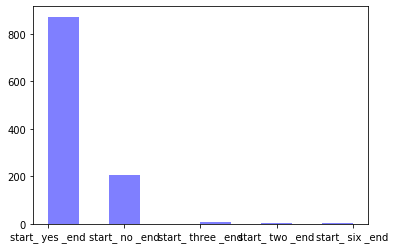

In [18]:
plt.hist(temp_french_list, 10,
         histtype='bar',
         facecolor='b',
         alpha=0.5)
plt.show()

From the above graph we can observe that 
<b>yes</b> and <b>no</b> replies are the most common frenchs in the mails 

number of email don' have any reply : 0
**************************************************
Max length : 932
**************************************************
Min Length : 12
**************************************************
Average Length : 36.72163181350703
**************************************************
No of unique replies : 168
**************************************************
--------------------------------------------------
Distribution of the words
--------------------------------------------------


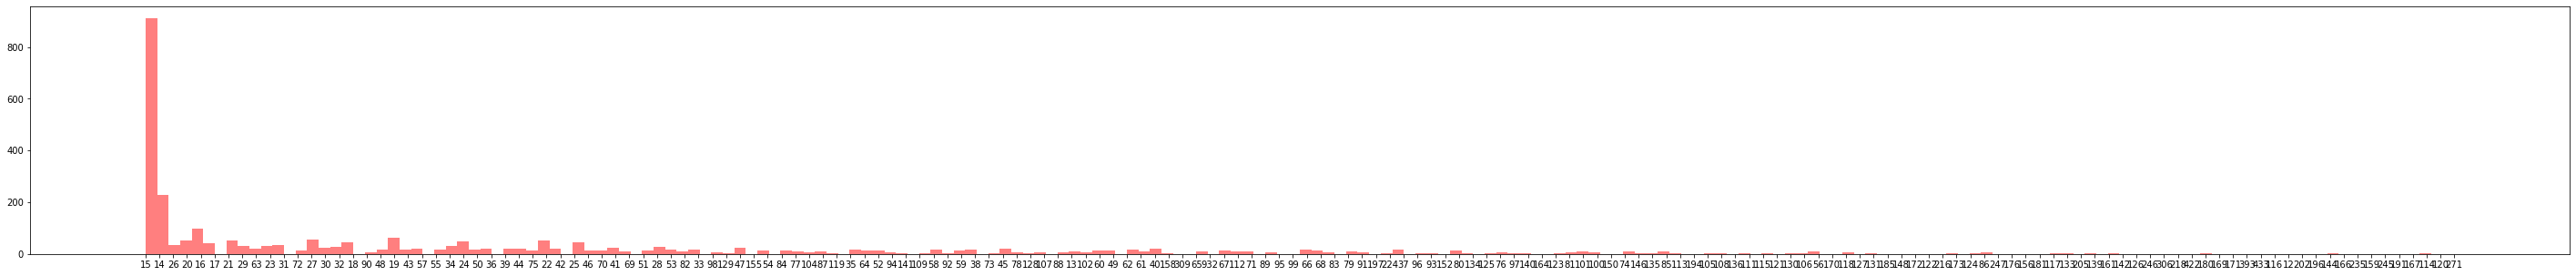

In [19]:
import matplotlib
matplotlib.rc('figure', figsize=[50,5])
#Getting the length of each french
data["french Length"]= data["french"].str.len()
len_frenchs = data["french Length"].values

#converting datatype to string
len_str_arr = []
for num in len_frenchs:
  len_str_arr.append(str(num)) 

no_reply_counter = 0
for num in len_frenchs:
  if num == 0:
    no_reply_counter += 1

temp_arr = []
for indx in len_frenchs:
  if indx == 0:
    continue
  else:
    temp_arr.append(indx)
    
print("number of email don' have any reply", end = ' : ')
print(no_reply_counter)
print('*' * 50)

print('Max length', end = ' : ')
print(max(list(len_frenchs)))
print('*' * 50)

print('Min Length', end = ' : ')
print(min(list(temp_arr)))
print('*' * 50)

print("Average Length", end = ' : ')
print((sum(list(len_frenchs)))/(len(list(len_frenchs))))
print('*' * 50)

print("No of unique replies", end = ' : ')
print(len(list(set(len_frenchs))))
print('*' * 50)


print('-' * 50)
print("Distribution of the words")
print('-' * 50)

plt.hist(len_str_arr, 200,
         histtype='bar',
         facecolor='r',
         alpha=0.5)
plt.show()

In [0]:
# data['french'] = 'start_ ' + data['french'] + ' _end'

From above graphs and data we observed that <b>maximun replies have less words. </b><br><br>
and <b>average length</b> if reply is nearly <b>25</b> words<br><br>
We have <b>169</b> unique replies


<h2> Check for emails </h2>

In [0]:
all_Englishs = data['English'].values

In [0]:
#Preprocessing Englishs 
#Remove the full stops from the dataframe frenchs

bad_chars = [';', ':', '!', "*",'.',')','(','?']

preprocessed_English = []
for English in all_Englishs:
  for i in bad_chars : 
    English = English.replace(i, '')
  preprocessed_English.append(English)



<h3> Words stemming </h3>

In [0]:
#Performing stammering here
# We are having less data
from nltk.stem import PorterStemmer
porter = PorterStemmer()
stemmed_sent = []
for sent in preprocessed_English:
  word_arr = []
  for word in sent.split():
    word_arr.append(porter.stem(word))
  temp_str = ""
  for words in word_arr:
    temp_str += words + " "
  stemmed_sent.append(temp_str)

In [0]:
data['English'] = stemmed_sent

In [0]:
#trimming the string the dataframe  
#because after removal of the special character trimming might have lost
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)


number of email don' have any reply : 0
**************************************************
Max length : 236
**************************************************
Min Length : 4
**************************************************
Average Length : 46.40281110730202
**************************************************
No of unique replies : 144
**************************************************
--------------------------------------------------
Distribution of the words
--------------------------------------------------


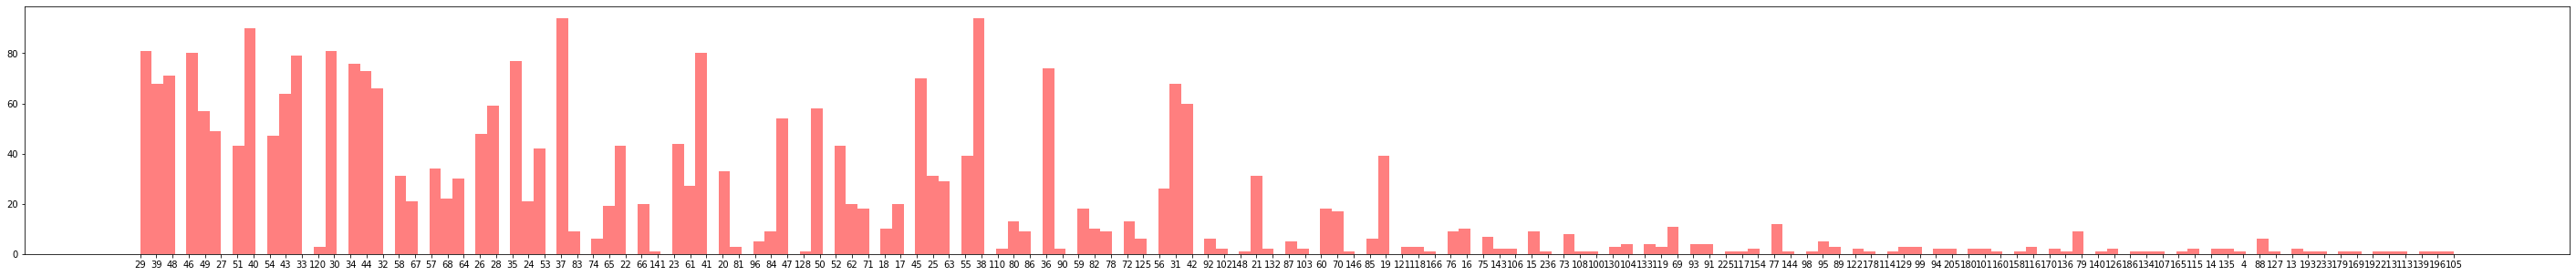

In [26]:
import matplotlib
matplotlib.rc('figure', figsize=[50,5])
#Getting the length of each french
data["English_length"]= data["English"].str.len()
len_Englishs = data["English_length"].values

#converting datatype to string
len_str_arr = []
for num in len_Englishs:
  len_str_arr.append(str(num)) 

no_reply_counter = 0
for num in len_Englishs:
  if num == 0:
    no_reply_counter += 1

temp_arr = []
for indx in len_Englishs:
  if indx == 0:
    continue
  else:
    temp_arr.append(indx)
    
print("number of email don' have any reply", end = ' : ')
print(no_reply_counter)
print('*' * 50)

print('Max length', end = ' : ')
print(max(list(len_Englishs)))
print('*' * 50)

print('Min Length', end = ' : ')
print(min(list(temp_arr)))
print('*' * 50)

print("Average Length", end = ' : ')
print((sum(list(len_Englishs)))/(len(list(len_Englishs))))
print('*' * 50)

print("No of unique replies", end = ' : ')
print(len(list(set(len_Englishs))))
print('*' * 50)


print('-' * 50)
print("Distribution of the words")
print('-' * 50)

plt.hist(len_str_arr, 200,
         histtype='bar',
         facecolor='r',
         alpha=0.5)
plt.show()

From the above graph we can observe that we have minimum of <b>4</b> character in the email<br><br>
maximum length of the Englishs is <b>270</b><br><br>
and we have unique distribution of <b>156</b> Englishs.

Top Unique distribution of Englishs in dataset

In [0]:
English_list = list(data['English'].values)
Englishs_dict = {i:English_list.count(i) for i in English_list}

In [0]:
from collections import OrderedDict
Englishs_dict_sorted = OrderedDict(sorted(Englishs_dict.items(), key=lambda x: x[1]))

In [29]:
Englishs_dict_sorted

OrderedDict([('wa volta an italian physicist', 1),
             ('is volta buri in the citi of pittsburgh', 1),
             ('did volta have a passion for the studi of electr', 1),
             ('what is the batteri made by volta credit to be', 1),
             ('where did volta enter retir', 1),
             ('is it a disadvantag for someth to be unsaf to handl', 1),
             ("wa lombardi under napoleon' rule in 1800", 1),
             ('wa the italian 10000 lira banknot creat befor the euro', 1),
             ('for how mani year did alessandro volta live', 1),
             ('did alessandro volta live to be 80 year old', 1),
             ('what wa alessandro volta` profess', 1),
             ('how old wa alessandro volta when he die', 1),
             ('how mani year ago wa it when volta marri the daughter of count ludovico peregrini , teresa , with whom he rais three son',
              1),
             ('is the electrolyt sulphur acid', 1),
             ('is volta buri in the 

In [0]:
Englishs = []
keys = []
for item in Englishs_dict_sorted.items():
  Englishs.append(item[0])
  keys.append(item[1])

In [0]:
Englishs.reverse()
keys.reverse()

In [0]:
#top 10 frenchs
top_5_Englishs = Englishs[:5]
top_5_keys = keys[:5]

In [0]:
temp_Englishs_list = []
i = 0
for key in top_5_keys:
  for _ in range(0,key):
    temp_Englishs_list.append(top_5_Englishs[i])
  i += 1

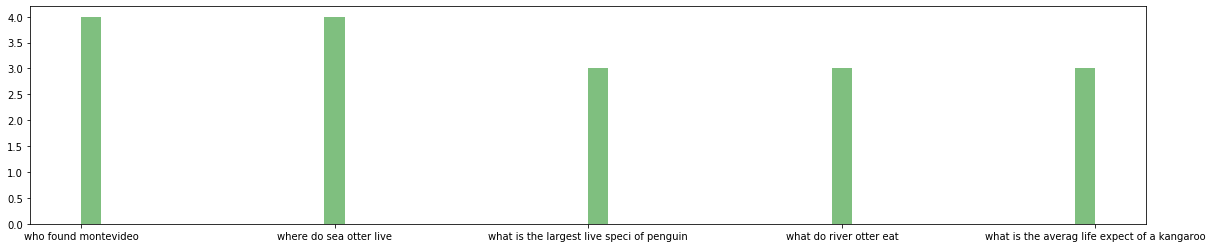

In [34]:
import matplotlib
matplotlib.rc('figure', figsize=[20,4])
plt.hist(temp_Englishs_list, 50,
         histtype='bar',
         facecolor='g',
         alpha=0.5)
plt.show()

Here we can see the top 5 repeated Englishs,<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; It's not looking usefull for any interpretation

In [35]:
print(data.head(5))
print(data.tail(5))

                  1  ... English_length
0  alessandro_volta  ...             29
1  alessandro_volta  ...             39
2  alessandro_volta  ...             48
3  alessandro_volta  ...             46
4  alessandro_volta  ...             49

[5 rows x 8 columns]
                   1  ... English_length
2912  woodrow_wilson  ...             60
2913  woodrow_wilson  ...            196
2914  woodrow_wilson  ...             95
2915  woodrow_wilson  ...            105
2916  woodrow_wilson  ...             19

[5 rows x 8 columns]


Here we can <b>combine the Article Title with the English</b> which can help in getting better suggestions.

<b>Modelling Approaches:<br><i>
# here before modeling we can stammer the sentences : Playing ko play
* Seq2seq model
* Bi-Directional LSTM
* Attention Layer
* Beam Search</b></i>

# Modeling

In [0]:
# Vocabulary of English
all_email_words=[]
for quest in data.English:
    for word in quest.split():
        if word not in all_email_words:
            all_email_words.append(word)

# Vocabulary of Replies 
all_reply_words=[]
for mar in data.french:
    for word in mar.split():
        if word not in all_reply_words:
            all_reply_words.append(word)

In [0]:
all_email_words = list(set(all_email_words))

In [0]:
all_reply_words = list(set(all_reply_words))

In [39]:
import numpy as np
lenght_list=[]
for l in data.English.values:
    lenght_list.append(len(l.split(' ')))
max_length_src = max(lenght_list)
max_length_src

44

In [40]:
lenght_list=[]
for l in data.french:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
max_length_tar

158

In [41]:

#All input words
input_words = sorted(list(all_email_words))
target_words = sorted(list(all_reply_words))

# get the length of the vocabalary // Kitne words // this will help while performing embedding layer
num_encoder_tokens = len(all_email_words) + 1
num_decoder_tokens = len(all_reply_words) + 1

num_encoder_tokens, num_decoder_tokens

(3672, 3776)

In [0]:
# from word to token we can get
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [0]:
# from token to word we can get
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [44]:
from sklearn.utils import shuffle
data = shuffle(data)
data.head(2)

,1,English,french,qw,ed,rf,french Length,English_length
2599,qatar,when did qatar becom an independ state,"start_ september 3, 1971 _end",medium,medium,data/set2/a3,29,38
15,alessandro_volta,is the electrolyt sulphur acid,start_ yes _end,nan,easy,data/set4/a10,15,30


In [45]:
# Train - Test Split
from sklearn.model_selection import train_test_split
X, y = data.English, data.french
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((2625,), (292,))

In [0]:
Englishs = X.values
frenchs =  y.values

all_txt_data = English + frenchs

In [0]:
# #this is the final data after removing the top 20percentile and data after last 80 percentile
# #reference https://keras.io/preprocessing/text/
# #https://stackoverflow.com/Englishs/51956000/what-does-keras-tokenizer-method-exactly-do
# from keras.preprocessing.text import Tokenizer
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(all_txt_data)

# tokenized_train_x = tokenizer.texts_to_sequences(X_train)
# tokenized_test_x = tokenizer.texts_to_sequences(X_test)

In [0]:

# tokenized_train_y = tokenizer.texts_to_sequences(y_train)
# tokenized_test_y = tokenizer.texts_to_sequences(y_test)

In [0]:
# #Padding for all data 

# #taking 1500 as the maximum number of essay contains nearty 1500 words
# from keras.preprocessing.sequence import pad_sequences
# padded_train_x = pad_sequences(tokenized_train_x,maxlen=1500,padding='post', truncating='post')
# padded_test_x = pad_sequences(tokenized_test_x,maxlen=1500,padding='post', truncating='post')

# padded_train_y = pad_sequences(tokenized_train_y,maxlen=1500,padding='post', truncating='post')
# padded_test_y = pad_sequences(tokenized_test_y,maxlen=1500,padding='post', truncating='post')




In [0]:
all_words = list(set(all_email_words + all_reply_words))

In [0]:
vocab_len = len(all_words)
latent_dim = 300

In [0]:
# import pickle
# glove_pickel = open("drive/My Drive/DonarChoose/glove_vectors","rb")
# glove_ = pickle.load(glove_pickel)

In [0]:
# vector = glove_.get(word)

In [0]:
# embedded_matrix = np.zeros((vocab_len, latent_dim))
# for word, i in tokenizer.word_index.items():
#     vector = glove_.get(word)
#     if vector is not None:
#       embedded_matrix[i] = vector
# print(embedded_matrix.shape)

In [54]:
#https://stackoverflow.com/Englishs/56097089/how-to-fix-name-embedding-is-not-defined-in-keras
from keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, concatenate,Embedding
# embedded_layer = Embedding(vocab_len,latent_dim,weights=[embedded_matrix],input_length=1500,trainable=False) # we are using the embedded matrix to get the weights which we initialize randomly in embedded layer

Using TensorFlow backend.


In [0]:
def generate_batch(X, y, batch_size=1000):
    while True:
      # in every batch we are sending (batch_size) of sentences
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),
                    dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),
                    dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar,
                    num_decoder_tokens), dtype='float32')

            # for all the sentences in the batch
            for (i, (input_text, target_text)) in enumerate(zip(X[j:j
                    + batch_size], y[j:j + batch_size])):

                # for words in each sentence //English
                for (t, word) in enumerate(input_text.split()):  # English wale text ko tokenize kiya gaya
                    encoder_input_data[i,t] = input_token_index[word]  # encoder input seq

                # for each word in   Sentence
                for (t, word) in enumerate(target_text.split()):  # t is the length of the sentence
                    if t < len(target_text.split()):
                        decoder_input_data[i,t] = target_token_index[word]  # decoder input seq
                    if t > 0:
                        #one-hot encoding 
                        #and making it to the output shape from decoder
                        decoder_target_data[i, t - 1,
                                target_token_index[word]] = 1.
                                                       
            return ([encoder_input_data, decoder_input_data],
                   decoder_target_data)  # this will help multiple return// like closure in swift


In [56]:
generate_batch

<function __main__.generate_batch>

In [57]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,CuDNNLSTM,Concatenate
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

# Encoder
latent_dim = 64 # how much dimension of output we want form the embedding layer
encoder_inputs = Input(shape=(None,)) # mentioning the input shape row and collumns are still null

# **num_encoder_tokens** vocabulary size we are having

enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs) #Embedding layer # this layer will make it 3D
# enc_emb = embedded_layer(encoder_inputs)
#training the LSTM on encoder
encoder_lstm = Bidirectional(LSTM(128, return_sequences=True, return_state=True))
encoder_output, forward_h, forward_c, backward_h, backward_c = encoder_lstm(enc_emb)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])


encoder_states = [state_h, state_c] #output and the cell state




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:

#  Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,)) #Reply's input
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True) 
dec_emb = dec_emb_layer(decoder_inputs) # Reply sikhaye hum Embedding layer ko


# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.


decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_output, decoder_h, decoder_c = decoder_lstm(dec_emb,initial_state=encoder_states)


decoder_states = [decoder_h, decoder_c]

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_output)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [59]:
model.save_weights('nmt_weights.h5')

In [0]:
model.load_weights('nmt_weights.h5')

In [0]:
model.save('my_model.h5')

<h3> Adding Attention layer </h3>

In [0]:
# from keras.models import load_model
# custom_objects = {
#     'AttentionLayer':AttentionLayer
# }
# model = load_model('my_model.h5',custom_objects = custom_objects)

In [63]:
encoder_output.shape

TensorShape([Dimension(None), Dimension(None), Dimension(256)])

In [64]:
decoder_output.shape

TensorShape([Dimension(None), Dimension(None), Dimension(256)])

In [65]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [66]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     235008      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, None, 256),  197632      embedding_1[0][0]                
____________________________________________________________________________________________

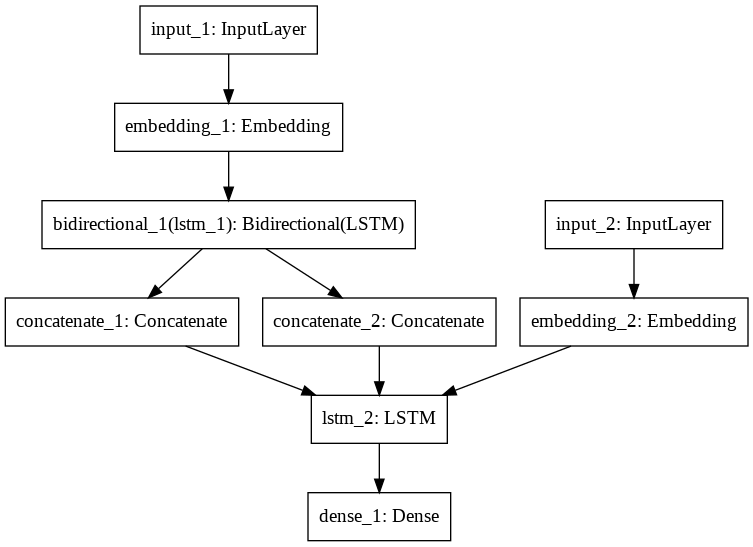

In [67]:
from keras.utils import plot_model
plot_model(model, to_file='multilayer_perceptron_graph.png')

In [0]:
temp = generate_batch(X_train, y_train, batch_size = len(X_train.values))
a  = temp[0]
b  = temp[1]
# c,d = generate_batch(X_test, y_test, batch_size = len(X_test.values))

In [0]:
# import numpy as np
# model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = 100),
#                     steps_per_epoch = len(X_train),
#                     epochs=10,
#                     validation_data = generate_batch(X_test, y_test, batch_size = 100),
#                     validation_steps = len(X_test)
#                     )


In [69]:
b.shape

(2625, 158, 3776)

In [131]:
model.fit(a,b,batch_size=100,epochs=50,verbose=1)

Epoch 1/50
2625/2625 [==============================] - 14s 5ms/step - loss: 1.6552 - acc: 0.5194
Epoch 2/50
2625/2625 [==============================] - 14s 5ms/step - loss: 1.6139 - acc: 0.5294
Epoch 3/50
2625/2625 [==============================] - 14s 5ms/step - loss: 1.5952 - acc: 0.5332
Epoch 4/50
2625/2625 [==============================] - 14s 5ms/step - loss: 1.5427 - acc: 0.5433
Epoch 5/50
2625/2625 [==============================] - 14s 5ms/step - loss: 1.4961 - acc: 0.5536
Epoch 6/50
2625/2625 [==============================] - 14s 5ms/step - loss: 1.4550 - acc: 0.5605
Epoch 7/50
2625/2625 [==============================] - 14s 5ms/step - loss: 1.4134 - acc: 0.5673
Epoch 8/50
2625/2625 [==============================] - 14s 5ms/step - loss: 1.3738 - acc: 0.5769
Epoch 9/50
2625/2625 [==============================] - 14s 5ms/step - loss: 1.3414 - acc: 0.5849
Epoch 10/50
2625/2625 [==============================] - 14s 5ms/step - loss: 1.3008 - acc: 0.5940
Epoch 11/50
2625/26

In [132]:
 
encoder_output

<tf.Tensor 'bidirectional_1/concat:0' shape=(?, ?, 256) dtype=float32>

# Inference

In [0]:
#Making new model so that we can predict the output
# taking all input and output of the encoder from the previous model to here
    #encoder_inputs: It's the tokenized and padded words from the English
encoder_model = Model(encoder_inputs, encoder_states) # this is not used for the input in the LSTM

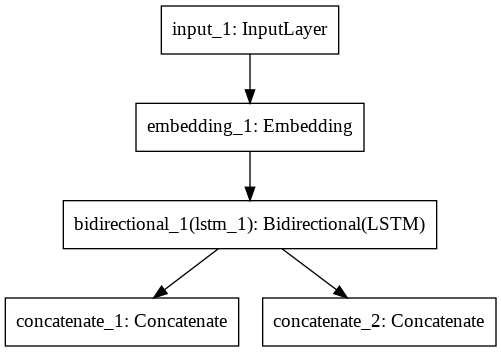

In [134]:
from keras.utils import plot_model
plot_model(encoder_model, to_file='multilayer_perceptron_graph.png')

In [135]:
encoder_model.summary()


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     235008      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, None, 256),  197632      embedding_1[0][0]                
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][3]      

___

In [0]:
#giving input to decoder
decoder_state_input_h = Input(shape=(256,)) # this will be the input form the encoders # cz 256 is from the encoder after concatination 
decoder_state_input_c = Input(shape=(256,)) #cell state after the encoder

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

#Reply words tokenized
dec_emb2= dec_emb_layer(decoder_inputs) #Get the embeddings of the decoder sequence

#decoder ka output and cell state nikal liya 
    # decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
        # here dec_emb2 we passed the output from the embedding later which for trained on tokenized sentensed of Reply words
decoder_outputs, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)

#added both states from the decoder 
decoder_states = [state_h2, state_c2]  

# Passing the output from the decoder model to the dense layer
decoder_output_dense = decoder_dense(decoder_outputs)

# Final decoder model
# decoder_inputs : Embedding layer ko Reply sentence tokenized
# decoder_states_inputs : this is from the encoder
# decoder_outputs2 : #ye decoder ka output he //predicted values from the decoder not the cellstate or output(h)
# decoder_states2 : #ye output(h) & cell state h from decoder # not form LSTm this is coming after the dense layer


decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_output_dense] + decoder_states)

In [137]:
print(decoder_model.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     241664      input_2[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 256)          0                                            
____________________________________________________________________________________________

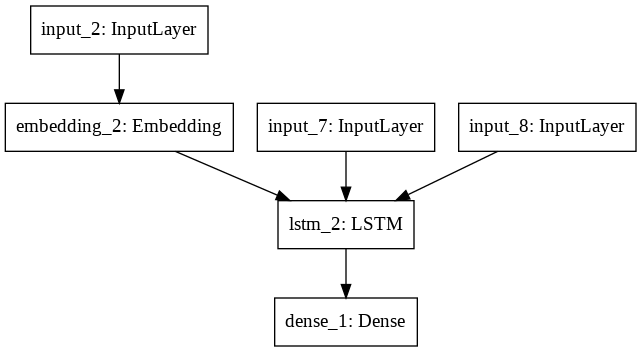

In [138]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='multilayer_perceptron_graph.png')

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['start_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) #need to check this logic 
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_end' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [0]:
def generate_batch(X, y, batch_size):
    while True:
      # in every batch we are sending (batch_size) of sentences
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),
                    dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),
                    dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar,
                    num_decoder_tokens), dtype='float32')

            # for all the sentences in the batch
            for (i, (input_text, target_text)) in enumerate(zip(X[j:j
                    + batch_size], y[j:j + batch_size])):

                # for words in each sentence //English
                for (t, word) in enumerate(input_text.split()):  # English wale text ko tokenize kiya gaya
                    encoder_input_data[i,t] = input_token_index[word]  # encoder input seq

                # for each word in   Sentence
                for (t, word) in enumerate(target_text.split()):  # t is the length of the sentence
                    if t < len(target_text.split()):
                        decoder_input_data[i,t] = target_token_index[word]  # decoder input seq
                    if t > 0:
                        #one-hot encoding 
                        #and making it to the output shape from decoder
                        decoder_target_data[i, t - 1,
                                target_token_index[word]] = 1.
                                                       
            yield ([encoder_input_data, decoder_input_data],
                   decoder_target_data)  # this will help multiple return// like closure in swift


In [0]:
train_gen = generate_batch([X_train.values[29]], [y_train.values[29]], batch_size = 1)
k=-1

In [0]:

(input_seq, actual_output), end_temp = next(train_gen)

In [192]:
predicted_sentence = decode_sequence(input_seq)
print('question/email: ',X_train.values[29])
reply = y_train.values[29].replace('start_', '')
reply = reply.replace('_end','.')
print('original reply: ',reply)
predicted_txt = predicted_sentence.replace('_end','.')
print('predicted reply: ',predicted_txt)

question/email:  who ha it own polit legislatur and governor
original reply:   each province .
predicted reply:   each province .


(1, 1, 3776)
(1, 1, 3776)
(1, 1, 3776)


' each province _end'

In [150]:
input_seq

array([[3570., 3283., 2599., 2387., 1935., 2080.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]],
      dtype=float32)

In [151]:
decode_sequence(input_seq)

(1, 1, 3776)
(1, 1, 3776)
(1, 1, 3776)


' 16 million _end'

In [152]:
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Reply :', y_train[k:k+1].values[0][6:-4])
print('Predicted Reply :', decoded_sentence[:-4])

(1, 1, 3776)
(1, 1, 3776)
(1, 1, 3776)


IndexError: ignored

In [0]:
k+=1
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Reply:', y_train[k:k+1].values[0][6:-4])
print('Predicted Reply:', decoded_sentence[:-4])